# Technical Analysis

The goal of this project is to investigate popular technical indicator used to forecast trend of underlying ticker. Lets see if they work!

## Load Data

Select a wide variety of data to test whether indicator performance is based on type of underlying. Thus, the underlying we'll investigate on are:

- SSW.JO: Sibanye Stillwater (highly volatile South African stock in the Mining & Energy sector).

- PPE.JO: Purple Group (lowly volatile South African stock in Financial Services sector).

- SPY: The famous S&P500 ETF, representing broad U.S. equity market exposure.

- ^TYX: The US 30-Yr Treasury Yield, a key macroeconomic interest rate indicator.

- EZA: The iShares MSCI South Africa ETF, a proxy for South African equity market.

- USDZAR=X: The USD/ZAR exchange rate, representing currency risk and macroeconomic sentiment.

- BTC-USD: Bitcoin priced in USD, a highly volatile and non-traditional asset class.

NB: The underlying data is sourced from Yahoo Finance. While its not the most reliable or precise data provider, it is sufficient for exploratory analysis and prototyping.

In [1]:
#Import libraries & Yahoo Finance API
import datetime, time
import yfinance as yfin
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import itertools

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.options.display.float_format = "{:,.6f}".format #Set decimal places

In [162]:
# Starting and end dates
start = datetime.date(2020, 6, 1)
end = datetime.date(2025, 11, 6)

!pip install curl_cffi -U
from curl_cffi import requests
session = requests.Session(impersonate = 'chrome')

# Get SA stock data
df = yfin.download(["SSW.JO", "PPE.JO"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get US ETF & Treasury Yield data
df_etf = yfin.download(["SPY", "^TYX", "EZA"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get Weekend data
df_wkd = yfin.download(["USDZAR=X"], start, end, auto_adjust = False, session = session)["Adj Close"]
df_wkd1 = yfin.download(["BTC-USD"], start, end, auto_adjust = False, session = session)["Adj Close"]

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [164]:
#Get High Prices
# Get SA stock data
df_h = yfin.download(["SSW.JO", "PPE.JO"], start, end, auto_adjust = False, session = session)["High"]

# Get US ETF & Treasury Yield data
df_etf_h = yfin.download(["SPY", "^TYX", "EZA"], start, end, auto_adjust = False, session = session)["High"]

# Get Weekend data
df_wkd_h = yfin.download(["USDZAR=X"], start, end, auto_adjust = False, session = session)["High"]
df_wkd1_h = yfin.download(["BTC-USD"], start, end, auto_adjust = False, session = session)["High"]

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [165]:
#Get Low Prices
# Get SA stock data
df_l = yfin.download(["SSW.JO", "PPE.JO"], start, end, auto_adjust = False, session = session)["Low"]

# Get US ETF & Treasury Yield data
df_etf_l = yfin.download(["SPY", "^TYX", "EZA"], start, end, auto_adjust = False, session = session)["Low"]

# Get Weekend data
df_wkd_l = yfin.download(["USDZAR=X"], start, end, auto_adjust = False, session = session)["Low"]
df_wkd1_l = yfin.download(["BTC-USD"], start, end, auto_adjust = False, session = session)["Low"]

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


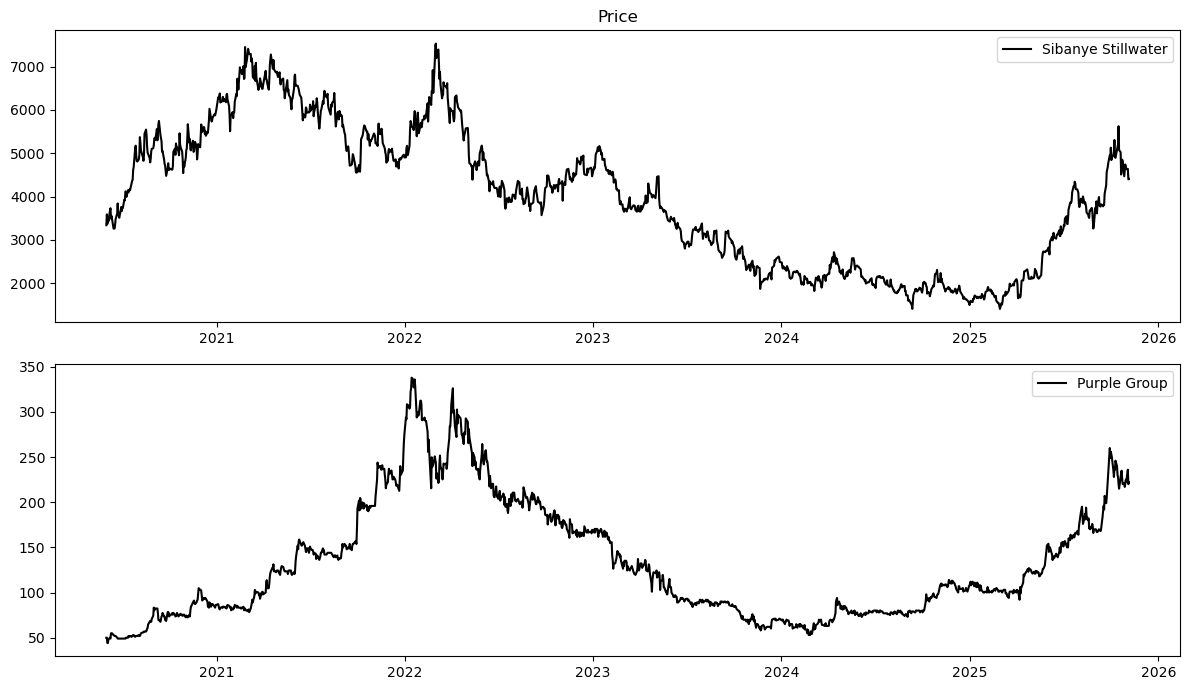

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

# Price Plot
axes[0].plot(df["SSW.JO"].index, df["SSW.JO"], label='Sibanye Stillwater', color='black')
axes[0].set_title('Price')
axes[0].legend()

axes[1].plot(df["PPE.JO"].index, df["PPE.JO"], label='Purple Group', color='black')
axes[1].legend()

plt.tight_layout()
plt.show()

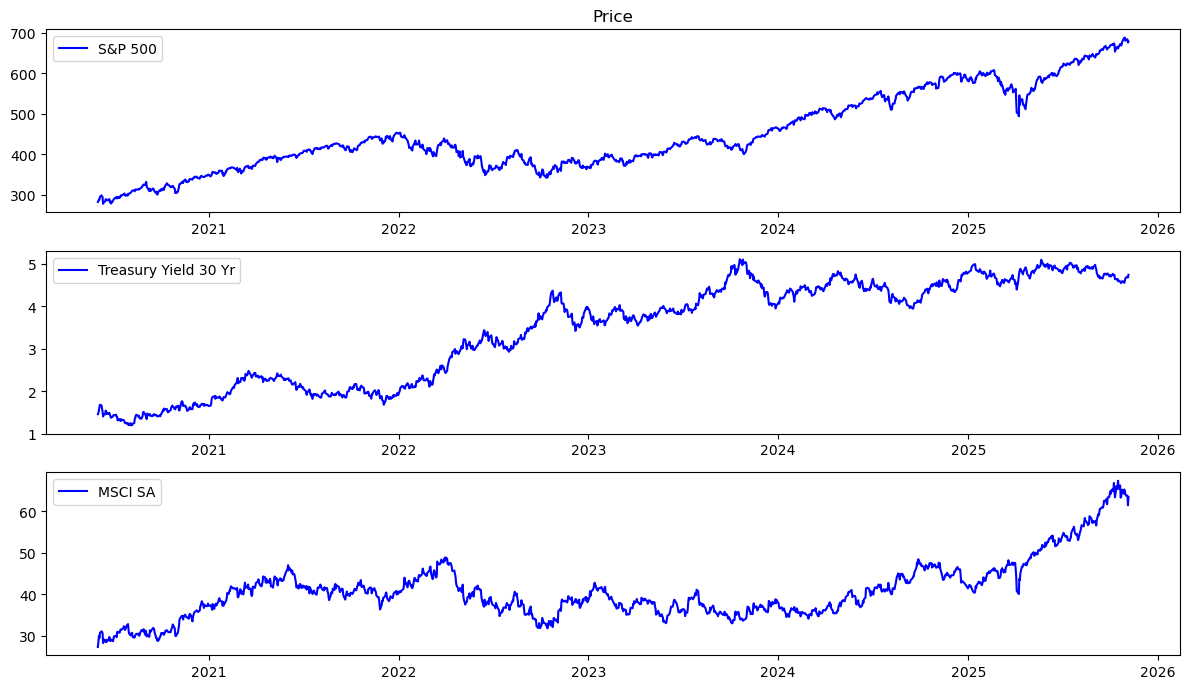

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7))

axes[0].plot(df_etf["SPY"].index, df_etf["SPY"], label='S&P 500', color='blue')
axes[0].set_title('Price')
axes[0].legend()

axes[1].plot(df_etf["^TYX"].index, df_etf["^TYX"], label='Treasury Yield 30 Yr', color='blue')
axes[1].legend()

axes[2].plot(df_etf["EZA"].index, df_etf["EZA"], label='MSCI SA', color='blue')
axes[2].legend()

plt.tight_layout()
plt.show()

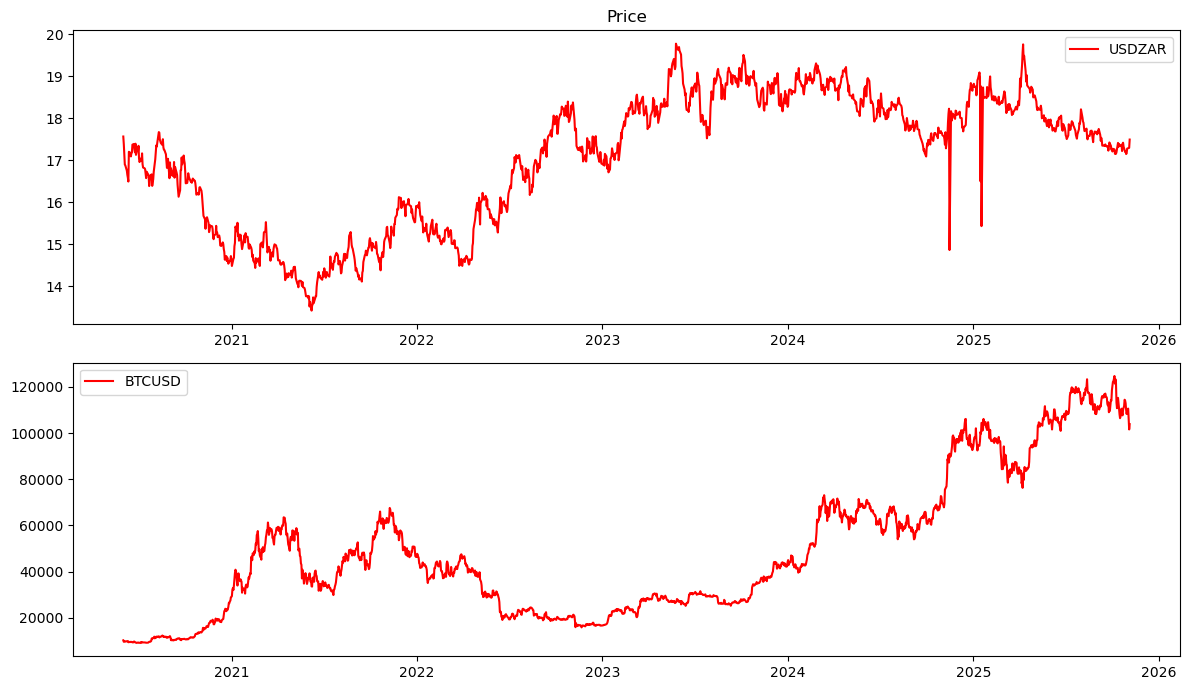

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

# Price Plot
axes[0].plot(df_wkd["USDZAR=X"].index, df_wkd["USDZAR=X"], label='USDZAR', color='red')
axes[0].set_title('Price')
axes[0].legend()

axes[1].plot(df_wkd1["BTC-USD"].index, df_wkd1["BTC-USD"], label='BTCUSD', color='red')
axes[1].legend()

plt.tight_layout()
plt.show()

# Relative Strength Indicator

In [7]:
##RSI Calculation
def calculate_rsi(prices, period=14):
    delta = prices.diff() # Calculate price changes
    
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain_series = pd.Series(gain, index=prices.index)
    loss_series = pd.Series(loss, index=prices.index)

    #Smoothed averages (reacts better to changing market momentum)
    avg_gain = gain_series.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss_series.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss # Relative Strength
    
    rsi = 100 - (100 / (1 + rs)) # RSI formula
    return rsi

In [8]:
##Trend Filter 
def trnd_fltr(dat, MA_lwr, MA_upp):
    dat['MA_lwr'] = dat['Price'].rolling(MA_lwr).mean() #Shorter window
    dat['MA_upp'] = dat['Price'].rolling(MA_upp).mean() #Longer window

    # Trend Identifier
    dat['Trend'] = np.where(dat['MA_lwr'] > dat['MA_upp'], 'Uptrend', 'Downtrend')

    return dat

In [9]:
#Assign values
def rez_id(bps_change):
    #Initiate
    bps_sucs = 0
    bps_gnd = 0
    bps_fail = 0
    bps_lst = 0

    #Conditions
    if bps_change > 0:
        bps_sucs = 1
        bps_gnd = bps_change
    else:
        bps_fail = 1
        bps_lst = abs(bps_change)

    return bps_sucs, bps_fail, bps_gnd, bps_lst

In [10]:
def metr_rsi_v3(data, start_date, end_date, lookahead=3, period=14, 
                         MA_lwr=50, MA_upp=200, rsi_bnch=(70, 30), plot=True):
    # Datetime index and proper slicing
    data = data.copy()
    data.index = pd.to_datetime(data.index)
    data = data.loc[start_date:end_date].sort_index()

    # Calculate RSI
    rsi = calculate_rsi(data, period=period)
    
    # Build working DataFrame
    data = pd.DataFrame({"Price": data, "RSI": rsi})

    # Identify crossovers
    data['RSI_prev'] = data['RSI'].shift(1)
    data['RSI_Cross'] = np.select([
        (data['RSI_prev'] < rsi_bnch[1]) & (data['RSI'] >= rsi_bnch[1]),
        (data['RSI_prev'] > rsi_bnch[0]) & (data['RSI'] <= rsi_bnch[0])
    ], ['Buy_Cross', 'Sell_Cross'], default='None')

    # Base signals (threshold logic)
    data['Signal'] = np.select(
        [data['RSI'] > rsi_bnch[0],
         data['RSI'] < rsi_bnch[1]],
        ['Sell', 'Buy'],
        default='Hold'
    )

    # Trend filter
    data = trnd_fltr(data, MA_lwr, MA_upp)

    # Performance testing
    results = []
    for i in range(len(data) - lookahead):
        current_price = data['Price'].iloc[i]
        future_price = data['Price'].iloc[i + lookahead]

        signal = data['Signal'].iloc[i]
        trend = data['Trend'].iloc[i]

        if signal == 'Buy':
            bps_chng = ((future_price - current_price) / current_price) * 10000
        elif signal == 'Sell':
            bps_chng = ((current_price - future_price) / current_price) * 10000
        else:
            # Follow the prevailing trend
            if trend == 'Uptrend':
                bps_chng = ((future_price - current_price) / current_price) * 10000
            else:
                bps_chng = ((current_price - future_price) / current_price) * 10000

        bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)

        results.append({
            'Date': data.index[i],
            'Signal': signal,
            'Trend': trend,
            'bps_change': bps_chng,
            '#Trades_Gain': bps_sucs,
            '#Trades_Lost': bps_fail,
            'bps_gained': bps_gnd,
            'bps_lost': bps_lst,
            'RSI': data['RSI'].iloc[i],
            'RSI_Cross': data['RSI_Cross'].iloc[i]
        })

    results_df = pd.DataFrame(results).set_index('Date')

    # Performance Summary
    summary = results_df.groupby(['Signal', 'Trend'])['bps_change'].agg(['count', 'mean', 'median', 'std'])
    win_rate = results_df.groupby(['Signal', 'Trend']).apply(lambda x: (x['bps_change'] > 0).mean() * 100).rename('Win_Rate(%)')
    
    summary = summary.join(win_rate)
    summary['Sharpe'] = summary['mean'] / summary['std']
    
    # Compute win/loss ratio and expected value
    gain_stats = results_df[results_df['bps_change'] > 0]['bps_change'].mean()
    loss_stats = abs(results_df[results_df['bps_change'] < 0]['bps_change'].mean())
    overall_wr = (results_df['bps_change'] > 0).mean() * 100

    summary['Win/Loss_Ratio'] = gain_stats / loss_stats if loss_stats != 0 else np.nan
    summary['Expected_Value'] = (overall_wr/100 * gain_stats) - ((1 - overall_wr/100) * loss_stats)

    # Visualization 
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        # Price Plot
        axes[0].plot(data.index, data['Price'], label='Price', color='black')
        axes[0].plot(data['MA_lwr'], label=f'MA{MA_lwr}', linestyle='--', alpha=0.6)
        axes[0].plot(data['MA_upp'], label=f'MA{MA_upp}', linestyle='--', alpha=0.6)

        buy_points = results_df[results_df['Signal'] == 'Buy'].index
        sell_points = results_df[results_df['Signal'] == 'Sell'].index

        axes[0].scatter(buy_points, data.loc[buy_points, 'Price'], color='green', marker='^', label='Buy Signal')
        axes[0].scatter(sell_points, data.loc[sell_points, 'Price'], color='red', marker='v', label='Sell Signal')
        axes[0].set_title('Price and Signals')
        axes[0].legend()

        # RSI Plot
        axes[1].plot(data.index, data['RSI'], label='RSI', color='blue')
        axes[1].axhline(rsi_bnch[0], color='red', linestyle='--', label=f'Overbought {rsi_bnch[0]}')
        axes[1].axhline(rsi_bnch[1], color='green', linestyle='--', label=f'Oversold {rsi_bnch[1]}')
        axes[1].set_title('RSI Levels')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    return summary, results_df

2020-06-01 00:00:00
2025-11-05 00:00:00


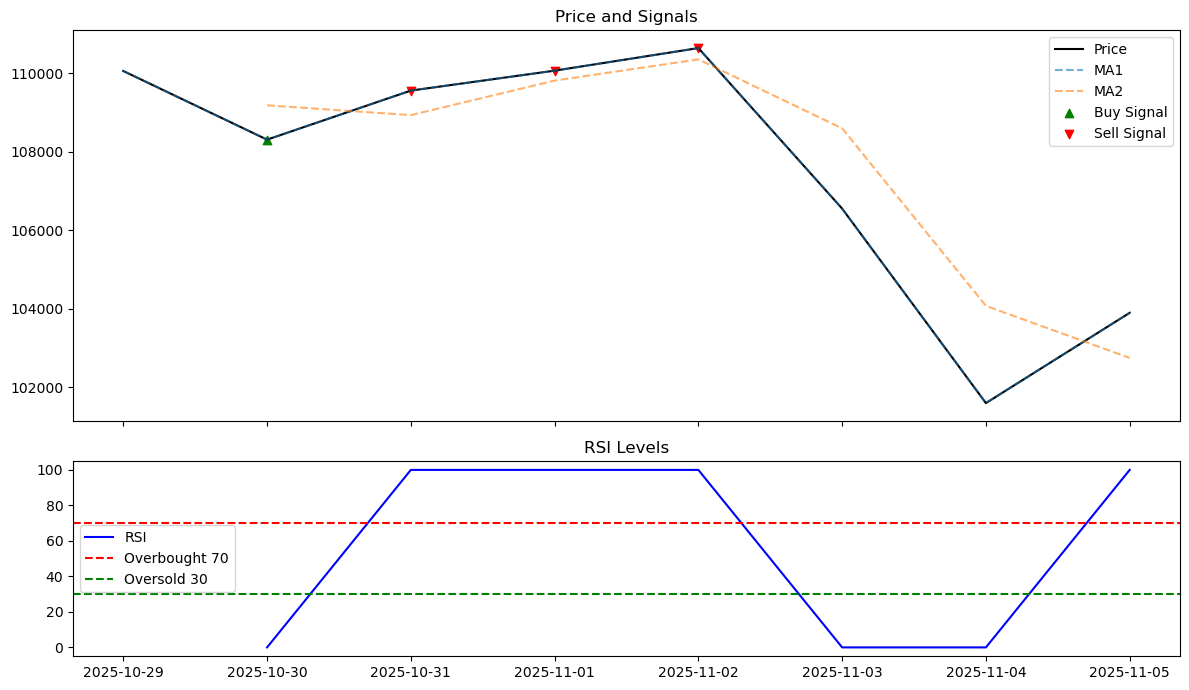

(                  count       mean     median        std  Win_Rate(%)  \
 Signal Trend                                                            
 Buy    Downtrend      1 215.508641 215.508641        NaN   100.000000   
 Hold   Downtrend      1  -0.791505  -0.791505        NaN     0.000000   
 Sell   Uptrend        3 551.459762 609.889003 252.741518   100.000000   
 
                    Sharpe  Win/Loss_Ratio  Expected_Value  
 Signal Trend                                               
 Buy    Downtrend      NaN      590.611187      373.819284  
 Hold   Downtrend      NaN      590.611187      373.819284  
 Sell   Uptrend   2.181912      590.611187      373.819284  ,
            Signal      Trend  bps_change  #Trades_Gain  #Trades_Lost  \
 Date                                                                   
 2025-10-29   Hold  Downtrend   -0.791505             0             1   
 2025-10-30    Buy  Downtrend  215.508641             1             0   
 2025-10-31   Sell    Uptrend 

In [33]:
#Function inputs:
    #Data - stock (adjusted) closing price
    #Start Date - The first date of analysis
    #End Date - The last date of analysis
    #NB: Analysis options include either duration measure (i.e. 1-,3-,6-month periods) or independently adjust start & end dates
    #Period - The duration of RSI measurement
    #Lookahead - Holding period, i.e. how many days you hold a stock before a 'new' position is taken
    #MA_lwr - Lower MA window in trend filter
    #MA_upp - Upper MA window in trend filter
    #rsi_upp - Upper bound for RSI 
    #rsi_lwr - Lower bound for RSI 

#Function outputs:
    #Summary - Computes metrics of bps change grouped by Signal & Trend
    #Results - Dataframe with results for each trading day position
    #Data - Output of RSI and Trend Filter trading strategy from price data

#An example: 2020, 6, 1)
print(df.index[-1] - pd.DateOffset(years=5, months=5, days=4))
print(df.index[-1])

metr_rsi_v3(data=df_wkd1["BTC-USD"] , start_date=df.index[-1] - pd.DateOffset(years=0, months=0, days=7), 
                                  end_date=df.index[-1], lookahead=3, MA_lwr=1, MA_upp=2, period=1, rsi_bnch=(70,30), plot=True)

In [34]:
# Start timer
start_time = time.time()

# Define dats
dats = [df["SSW.JO"], df["PPE.JO"], df_etf["SPY"], df_etf["^TYX"], df_etf["EZA"], df_wkd["USDZAR=X"], df_wkd1["BTC-USD"]]

# Define date ranges
starts = [
    df.index[-1] - pd.DateOffset(years=0, months=6),
    df.index[-1] - pd.DateOffset(years=0, months=3),
    df.index[-1] - pd.DateOffset(years=0, months=1),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=14),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=7)
]

ends = [
    df.index[-1]
]

# Other hyperparameters
lookaheads = [1, 2, 4, 7]
MA_lwrs = [1, 5, 7]
MA_upps = [7, 10, 14]
periods = [4, 7, 14]
rsi_bnchs = [(70, 30), (80, 20), (60, 40)]

# Define parameter grid
param_grid = list(itertools.product(
    dats, starts, ends, lookaheads, MA_lwrs, MA_upps, periods, rsi_bnchs
))

results = []
best_score = float('-inf')
less_score = float('inf')
best_params = None
less_params = None

def evaluate_params(params):
    dat, start, end, lookahead, MA_lwr, MA_upp, period, rsi_bnch = params

    if end <= start or MA_upp <= MA_lwr or (end.date() - start.date()).days <= MA_upp or lookahead >= MA_upp:
        return None

    try:
        f_summ, f_rez = metr_rsi_v3(data=dat, start_date=start, end_date=end, lookahead=lookahead,
            MA_lwr=MA_lwr, MA_upp=MA_upp, period=period, rsi_bnch=rsi_bnch, plot=False)
        score = f_summ['Expected_Value'].mean()

        return {
            'Data': dat.name,
            'Start': start,
            'End': end,
            'Lookahead': lookahead,
            'MA_lwr': MA_lwr,
            'MA_upp': MA_upp,
            'Period': period,
            'RSI_Benchmark': rsi_bnch,
            'Score': score
        }

    except Exception as e:
        print(f"Error for {dat.name}, {start}, {end}, {lookahead}, {MA_lwr}, {MA_upp}, {period}, {rsi_bnch}: {e}")
        return None

# Run grid search with progress bar and parallel execution
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(evaluate_params, param_grid), total=len(param_grid)):
        if result:
            results.append(result)
            score = result['Score']
            if score > best_score:
                best_score = score
                best_params = result
            if score < less_score:
                less_score = score
                less_params = result

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Output best and worst results
if best_params:
    print("\nBest combination found:")
    print(best_params)
    print(f"Avg BPS Gained: {best_score:.2f}")

if less_params:
    print("\nWorst combination found:")
    print(less_params)
    print(f"Avg BPS Lost: {less_score:.2f}")

# Total runtime
end_time = time.time()
print(f"\nTotal Run Time: {(end_time - start_time)/60:.2f} minutes")

100%|██████████| 11340/11340 [03:15<00:00, 57.97it/s] 


Best combination found:
{'Data': 'SSW.JO', 'Start': Timestamp('2025-08-05 00:00:00'), 'End': Timestamp('2025-11-05 00:00:00'), 'Lookahead': 7, 'MA_lwr': 1, 'MA_upp': 14, 'Period': 14, 'RSI_Benchmark': (70, 30), 'Score': 476.44202857214566}
Avg BPS Gained: 476.44

Worst combination found:
{'Data': 'PPE.JO', 'Start': Timestamp('2025-05-05 00:00:00'), 'End': Timestamp('2025-11-05 00:00:00'), 'Lookahead': 7, 'MA_lwr': 5, 'MA_upp': 14, 'Period': 14, 'RSI_Benchmark': (60, 40), 'Score': -348.6196715709624}
Avg BPS Lost: -348.62

Total Run Time: 3.29 minutes


In [35]:
# Print top results
print(results_df.sort_values(by='Score', ascending=False).dropna())

        Data      Start        End  Lookahead  MA_lwr  MA_upp  Period  \
501   SSW.JO 2025-08-05 2025-11-05          7       1      14      14   
749   SSW.JO 2025-10-05 2025-11-05          4       7      14       4   
695   SSW.JO 2025-10-05 2025-11-05          4       1      10       4   
704   SSW.JO 2025-10-05 2025-11-05          4       1      14       4   
731   SSW.JO 2025-10-05 2025-11-05          4       5      14       4   
...      ...        ...        ...        ...     ...     ...     ...   
1488  PPE.JO 2025-08-05 2025-11-05          7       5      14       7   
1205  PPE.JO 2025-05-05 2025-11-05          7       1      14      14   
1232  PPE.JO 2025-05-05 2025-11-05          7       7      10      14   
1241  PPE.JO 2025-05-05 2025-11-05          7       7      14      14   
1223  PPE.JO 2025-05-05 2025-11-05          7       5      14      14   

     RSI_Benchmark       Score  
501       (70, 30)  476.442029  
749       (60, 40)  458.184659  
695       (60, 40)  458.

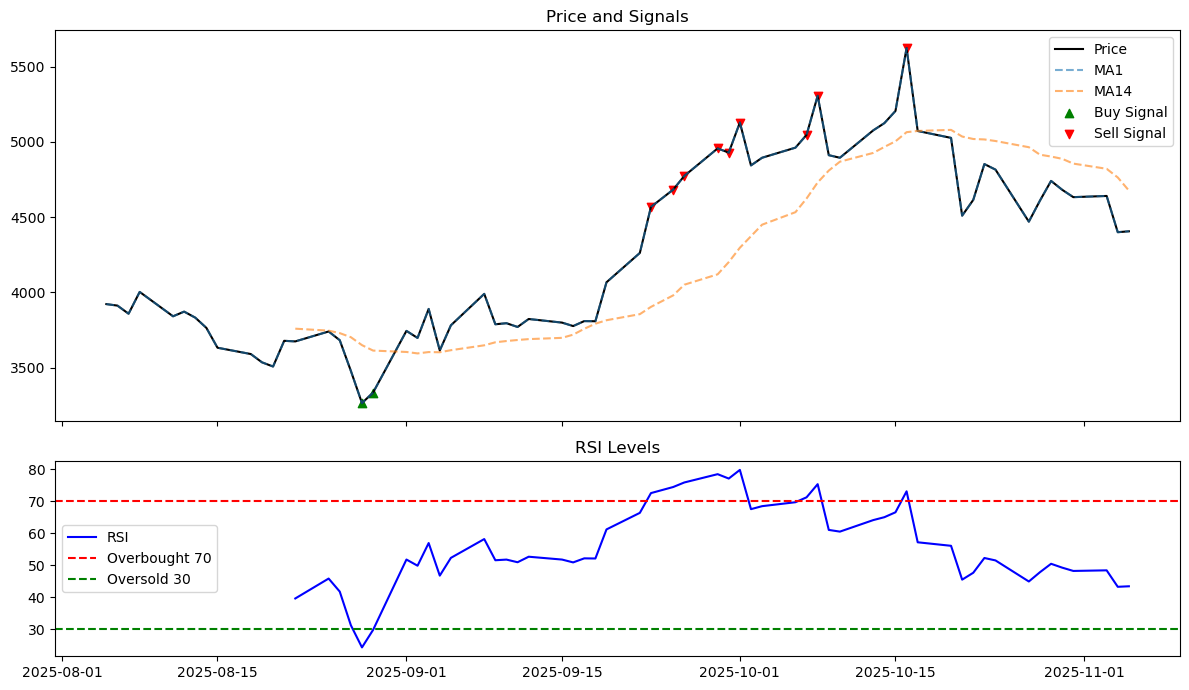

(                  count         mean       median          std  Win_Rate(%)  \
 Signal Trend                                                                  
 Buy    Downtrend      2 1,792.996180 1,792.996180   609.905798   100.000000   
 Hold   Downtrend     24   309.945893   407.586507   493.351981    70.833333   
        Uptrend       24   743.108912   475.437322 1,236.946106    70.833333   
 Sell   Uptrend        9   -83.247557  -571.847507   971.578455    44.444444   
 
                     Sharpe  Win/Loss_Ratio  Expected_Value  
 Signal Trend                                                
 Buy    Downtrend  2.939792        1.892349      476.442029  
 Hold   Downtrend  0.628245        1.892349      476.442029  
        Uptrend    0.600761        1.892349      476.442029  
 Sell   Uptrend   -0.085683        1.892349      476.442029  ,
            Signal      Trend    bps_change  #Trades_Gain  #Trades_Lost  \
 Date                                                                 

In [36]:
##Best combination
metr_rsi_v3(data=df["SSW.JO"], start_date=best_params['Start'], end_date=best_params['End'], lookahead=best_params['Lookahead'],
                                   MA_lwr=best_params['MA_lwr'], MA_upp=best_params['MA_upp'], period=best_params['Period'], 
            rsi_bnch=best_params['RSI_Benchmark'], plot=True)

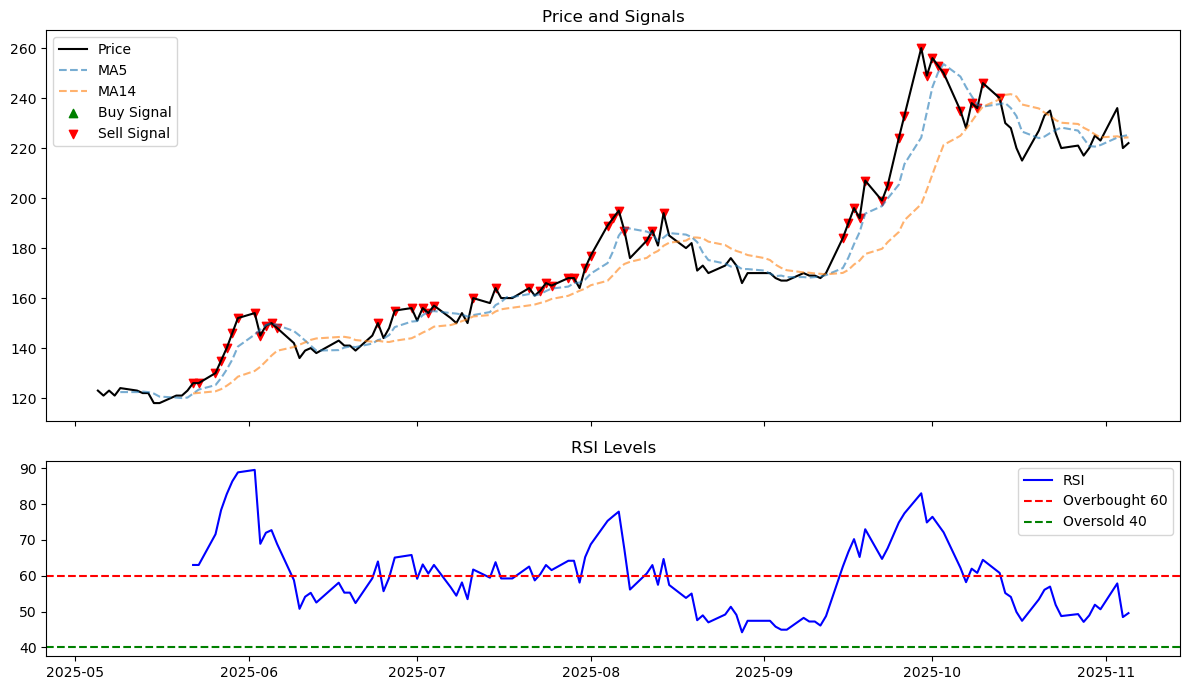

(                  count          mean        median          std  Win_Rate(%)  \
 Signal Trend                                                                    
 Hold   Downtrend     48   -467.291635   -106.035437   811.352923    35.416667   
        Uptrend       22    221.648323    328.682394   500.730894    68.181818   
 Sell   Downtrend      2 -1,006.944444 -1,006.944444 1,718.662315    50.000000   
        Uptrend       52   -353.806572    -31.250000 1,144.557396    48.076923   
 
                     Sharpe  Win/Loss_Ratio  Expected_Value  
 Signal Trend                                                
 Hold   Downtrend -0.575941        0.429888     -348.619672  
        Uptrend    0.442650        0.429888     -348.619672  
 Sell   Downtrend -0.585888        0.429888     -348.619672  
        Uptrend   -0.309121        0.429888     -348.619672  ,
            Signal      Trend  bps_change  #Trades_Gain  #Trades_Lost  \
 Date                                                       

In [37]:
##Worst combination  
metr_rsi_v3(data=df["PPE.JO"], start_date=less_params['Start'], end_date=less_params['End'], lookahead=less_params['Lookahead'],
                                   MA_lwr=less_params['MA_lwr'], MA_upp=less_params['MA_upp'], period=less_params['Period'], 
            rsi_bnch=less_params['RSI_Benchmark'], plot=True)

In [38]:
#Analysis
results_df1 = results_df

# Clean the Score column
results_df1['Score'] = results_df1['Score'].astype(str).str.replace(',', '').astype(float)

# Descriptive statistics
print("Descriptive Statistics for 'Score':")
print(results_df1['Score'].describe())

# Group-wise average scores by Data
group_summary = results_df1.groupby(['Data'])['Score'].mean().reset_index()

print("\n Parameter Combinations by Data:")
print(group_summary.sort_values(by='Score', ascending=False))

# By Lookahead
group_summary = results_df1.groupby(['Lookahead'])['Score'].mean().reset_index()

print("\n Parameter Combinations by Lookahead:")
print(group_summary.sort_values(by='Score', ascending=False))

# By Moving Averages
group_summary = results_df1.groupby(['MA_lwr', 'MA_upp'])['Score'].mean().reset_index()

print("\nTop Parameter Combinations by MA:")
print(group_summary.sort_values(by='Score', ascending=False))

# By Period
group_summary = results_df1.groupby(['Period'])['Score'].mean().reset_index()

print("\nTop Parameter Combinations by Period:")
print(group_summary.sort_values(by='Score', ascending=False))

# By RSI Benchmark
group_summary = results_df1.groupby(['RSI_Benchmark'])['Score'].mean().reset_index()

print("\nTop Parameter Combinations by RSI Benchmark:")
print(group_summary.sort_values(by='Score', ascending=False))

Descriptive Statistics for 'Score':
count   6,719.000000
mean       26.069496
std        87.981964
min      -348.619672
25%       -14.352212
50%         5.224089
75%        48.111302
max       476.442029
Name: Score, dtype: float64

 Parameter Combinations by Data:
       Data      Score
4    SSW.JO 107.300851
0   BTC-USD  47.847269
1       EZA  20.308068
2    PPE.JO  11.978985
6      ^TYX   1.141529
5  USDZAR=X  -2.158028
3       SPY  -6.193590

 Parameter Combinations by Lookahead:
   Lookahead     Score
3          7 42.578302
2          4 33.946776
1          2 23.443757
0          1  9.399865

Top Parameter Combinations by MA:
   MA_lwr  MA_upp     Score
1       1      10 35.614692
2       1      14 32.020378
4       5      10 29.979825
5       5      14 26.472516
6       7      10 25.576836
7       7      14 23.136819
0       1       7 18.120864
3       5       7 13.490225

Top Parameter Combinations by Period:
   Period     Score
0       4 32.532378
1       7 24.604524
2      14 

## Conclusion

From the above analysis, we observe that RSI works best on Sibanye Stillwater, within the period of 17 Oct 2024 to 17 July 2025. It had parameters: 

- Lookahead = 20: The underlying trading positions (i.e. buy, hold or sell) were changed after 20 business days, if need be.
- MA_lwr = 30: In determining underlying trend filter, the shorter window is 30 days
- MA_upp = 50: Upper window is 50 days.
- Period = 14: In calculation of underlying RSI metric, the most previous 14 closing prices were used to compute momentum.
- RSI_Benchmark = (80, 20): The RSI thresholds used where 80-20% for overbought and oversold regions.
- Score = 1117.62: This is the total basis point trade profit gained from following strategy.

The RSI seemed to not have effectively generated profit for the trader as the visual indicates that the trade gains were not due to RSI triggers.

Whilst the worst performing trading strategy indicated that RSI constantly indicated to take a bear position during an upward trending in Sibanye Stillwater share price.

# MA Cross

In [79]:
def moving_average_crossover(prices, short_window=50, long_window=200):
    if short_window <= 0 or long_window <= 0:
        raise ValueError("Moving average windows must be positive integers.")
    if short_window >= long_window:
        raise ValueError("short_window must be less than long_window.")

    # Calculate moving averages
    prices["Short_MA"] = prices["Price"].rolling(window=short_window, min_periods=1).mean()
    prices["Long_MA"] = prices["Price"].rolling(window=long_window, min_periods=1).mean()

    # Generate signals: 1 = Buy (Golden Cross), -1 = Sell (Death Cross), 0 = Hold
    prices["Signal"] = 'Hold'
    prices.loc[prices["Short_MA"] > prices["Long_MA"], "Signal"] = 'Buy'
    prices.loc[prices["Short_MA"] < prices["Long_MA"], "Signal"] = 'Sell'

    # Detect crossover points (change in signal)
    prices["Crossover"] = prices["Signal"] != prices["Signal"].shift(1)
    prices.iloc[0, prices.columns.get_loc("Crossover")] = False

    return prices

2020-06-01 00:00:00
2025-11-05 00:00:00


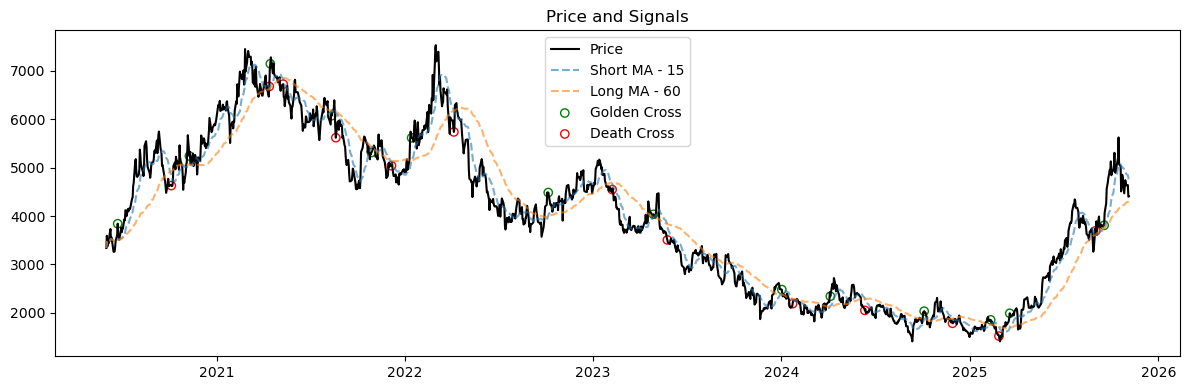

(Ticker            Price     Short_MA      Long_MA Signal  Crossover  \
Date                                                                  
2020-06-01 3,340.525879 3,340.525879 3,340.525879   Hold      False   
2020-06-02 3,590.965332 3,465.745605 3,465.745605   Hold      False   
2020-06-03 3,372.454590 3,434.648600 3,434.648600   Hold      False   
2020-06-04 3,512.141846 3,454.021912 3,454.021912   Hold      False   
2020-06-05 3,431.322510 3,449.482031 3,449.482031   Hold      False   
...                 ...          ...          ...    ...        ...   
2025-10-30 4,682.000000 4,888.266667 4,267.133333    Buy      False   
2025-10-31 4,633.000000 4,870.800000 4,280.050000    Buy      False   
2025-11-03 4,641.000000 4,841.733333 4,290.683333    Buy      False   
2025-11-04 4,400.000000 4,793.400000 4,300.000000    Buy      False   
2025-11-05 4,406.000000 4,740.066667 4,308.900000    Buy      False   

Ticker     Price Trend  
Date                    
2020-06-01   Downtrend  


In [151]:
def metr_ma_crx_v1(data, start_date, end_date, ma_upp, ma_lwr, lookahead, plot=True):
    data = data.copy()
    data.index = pd.to_datetime(data.index)

    #Slice Data
    data = data.loc[start_date:end_date].sort_index()
    
    data.rename(columns={data.columns[0]: "Price"}, inplace=True)
    
    #Apply technical
    ma_X = moving_average_crossover(prices=data, short_window=ma_lwr, long_window=ma_upp)

    #Actual Daily Price Trend
    ma_X['Price Trend'] = np.where(ma_X['Price'].diff()>0, 'Uptrend', 'Downtrend')
    
    # Performance testing
    results = []
    for i in range(len(ma_X) - lookahead):
        current_price = ma_X['Price'].iloc[i]
        future_price = ma_X['Price'].iloc[i + lookahead]
        
        signal = ma_X['Signal'].iloc[i]
        trend = ma_X['Price Trend'].iloc[i+1] 
        
        if signal == 'Buy':
            bps_chng = ((future_price - current_price) / current_price) * 10000
        elif signal == 'Sell':
            bps_chng = ((current_price - future_price) / current_price) * 10000
        else:
            # Follow the prevailing trend
            if trend == 'Uptrend':
                bps_chng = ((future_price - current_price) / current_price) * 10000
            else:
                bps_chng = ((current_price - future_price) / current_price) * 10000
                
        bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)
        
        results.append({
            'Date': ma_X.index[i],
            'Signal': signal,
            'Trend': trend,
            'bps_change': bps_chng,
            '#Trades_Gain': bps_sucs,
            '#Trades_Lost': bps_fail,
            'bps_gained': bps_gnd,
            'bps_lost': bps_lst
        })
    
    results_df = pd.DataFrame(results).set_index('Date')

    # Performance Summary
    summary = results_df.groupby(['Signal', 'Trend'])['bps_change'].agg(['count', 'mean', 'median', 'std'])
    win_rate = results_df.groupby(['Signal', 'Trend']).apply(lambda x: (x['bps_change'] > 0).mean() * 100).rename('Win_Rate(%)')
    
    summary = summary.join(win_rate)
    summary['Sharpe'] = summary['mean'] / summary['std']
    
    # Compute win/loss ratio and expected value
    gain_stats = results_df[results_df['bps_change'] > 0]['bps_change'].mean()
    loss_stats = abs(results_df[results_df['bps_change'] < 0]['bps_change'].mean())
    overall_wr = (results_df['bps_change'] > 0).mean() * 100

    summary['Win/Loss_Ratio'] = gain_stats / loss_stats if loss_stats != 0 else np.nan
    summary['Expected_Value'] = (overall_wr/100 * gain_stats) - ((1 - overall_wr/100) * loss_stats)
    
    # Visualization 
    if plot:
        fig, axes = plt.subplots(1, 1, figsize=(12, 4), sharex=True)

        # Price Plot
        axes.plot(ma_X.index, ma_X['Price'], label='Price', color='black')
        axes.plot(ma_X['Short_MA'], label=f'Short MA - {ma_lwr}', linestyle='--', alpha=0.6)
        axes.plot(ma_X['Long_MA'], label=f'Long MA - {ma_upp}', linestyle='--', alpha=0.6)

        gcrss_pnt = ma_X[(ma_X['Crossover'] == True) & (ma_X['Signal'] == 'Buy')].index
        dcrss_pnt = ma_X[(ma_X['Crossover'] == True) & (ma_X['Signal'] == 'Sell')].index

        axes.scatter(gcrss_pnt, ma_X.loc[gcrss_pnt, 'Price'], facecolors='none', edgecolors='green', marker='o', label='Golden Cross')
        axes.scatter(dcrss_pnt, ma_X.loc[dcrss_pnt, 'Price'], facecolors='none', edgecolors='red', marker='o', label='Death Cross')
        axes.set_title('Price and Signals')
        axes.legend()

        plt.tight_layout()
        plt.show()
    return ma_X, summary, results_df
    
print(df.index[-1] - pd.DateOffset(years=5, months=5, days=4))
print(df.index[-1])

print(metr_ma_crx_v1(data=df[["SSW.JO"]], start_date=df.index[-1] - pd.DateOffset(years=5, months=5, days=4), end_date=df.index[-1],
     ma_upp=60, ma_lwr=15, lookahead=4, plot=True))

In [136]:
# Start timer
start_time = time.time()

# Define dats
dats = [df[["SSW.JO"]], df[["PPE.JO"]], df_etf[["SPY"]], df_etf[["^TYX"]], df_etf[["EZA"]], df_wkd[["USDZAR=X"]], df_wkd1[["BTC-USD"]]]

# Define date ranges
starts = [
    df.index[-1] - pd.DateOffset(years=1, months=0),
    df.index[-1] - pd.DateOffset(years=0, months=6),
    df.index[-1] - pd.DateOffset(years=0, months=3),
    df.index[-1] - pd.DateOffset(years=0, months=1),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=14),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=7)
]

ends = [
    df.index[-1]
]

# Other hyperparameters
lookaheads = [1, 2, 4, 7]
MA_lwrs = [1, 5, 7]
MA_upps = [7, 10, 14]

# Define parameter grid
param_grid = list(itertools.product(
    dats, starts, ends, lookaheads, MA_lwrs, MA_upps
))

results = []
best_score = float('-inf')
less_score = float('inf')
best_params = None
less_params = None

def evaluate_params(params):
    dat, start, end, lookahead, MA_lwr, MA_upp = params

    if end <= start or MA_upp <= MA_lwr or (end.date() - start.date()).days <= MA_upp or lookahead >= MA_upp:
        return None

    try:
        f_dat, f_summ, f_rez = metr_ma_crx_v1(data=dat, start_date=start, end_date=end, ma_upp=MA_upp, ma_lwr=MA_lwr,
                                       lookahead=lookahead, plot=False)
        
        score = f_summ['Expected_Value'].mean()

        return {
            'Data': dat.columns[0],
            'Start': start,
            'End': end,
            'Lookahead': lookahead,
            'MA_lwr': MA_lwr,
            'MA_upp': MA_upp,
            'Score': score
        }

    except Exception as e:
        print(f"Error for {dat.columns[0]}, {start}, {end}, {lookahead}, {MA_lwr}, {MA_upp}: {e}")
        return None

# Run grid search with progress bar and parallel execution
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(evaluate_params, param_grid), total=len(param_grid)):
        if result:
            results.append(result)
            score = result['Score']
            if score > best_score:
                best_score = score
                best_params = result
            if score < less_score:
                less_score = score
                less_params = result

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Output best and worst results
if best_params:
    print("\nBest combination found:")
    print(best_params)
    print(f"Avg BPS Gained: {best_score:.2f}")

if less_params:
    print("\nWorst combination found:")
    print(less_params)
    print(f"Avg BPS Lost: {less_score:.2f}")

# Total runtime
end_time = time.time()
print(f"\nTotal Run Time: {(end_time - start_time)/60:.2f} minutes")

100%|██████████| 1512/1512 [00:26<00:00, 57.57it/s] 



Best combination found:
{'Data': 'SSW.JO', 'Start': Timestamp('2025-10-22 00:00:00'), 'End': Timestamp('2025-11-05 00:00:00'), 'Lookahead': 2, 'MA_lwr': 5, 'MA_upp': 10, 'Score': 364.8850609204279}
Avg BPS Gained: 364.89

Worst combination found:
{'Data': 'PPE.JO', 'Start': Timestamp('2025-10-05 00:00:00'), 'End': Timestamp('2025-11-05 00:00:00'), 'Lookahead': 4, 'MA_lwr': 1, 'MA_upp': 7, 'Score': -400.1810740450226}
Avg BPS Lost: -400.18

Total Run Time: 0.45 minutes


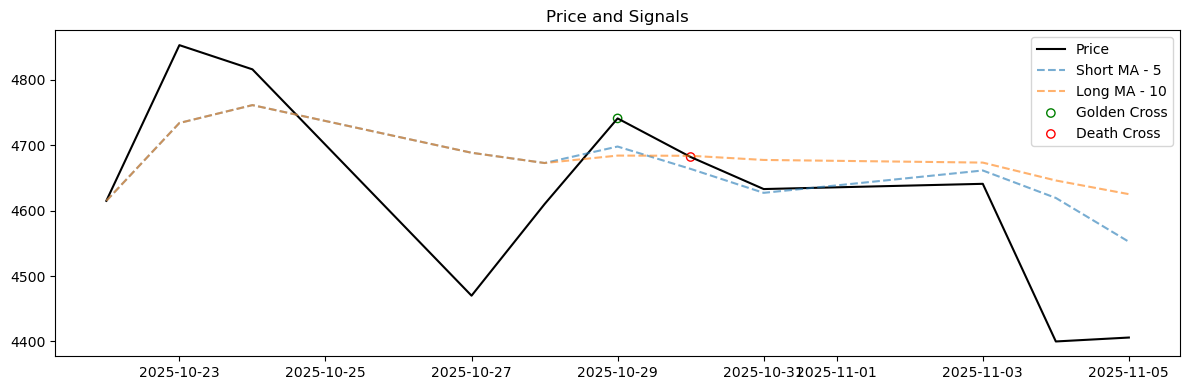

(Ticker            Price     Short_MA      Long_MA Signal  Crossover  \
 Date                                                                  
 2025-10-22 4,615.000000 4,615.000000 4,615.000000   Hold      False   
 2025-10-23 4,853.000000 4,734.000000 4,734.000000   Hold      False   
 2025-10-24 4,816.000000 4,761.333333 4,761.333333   Hold      False   
 2025-10-27 4,470.000000 4,688.500000 4,688.500000   Hold      False   
 2025-10-28 4,610.000000 4,672.800000 4,672.800000   Hold      False   
 2025-10-29 4,741.000000 4,698.000000 4,684.166667    Buy       True   
 2025-10-30 4,682.000000 4,663.800000 4,683.857143   Sell       True   
 2025-10-31 4,633.000000 4,627.200000 4,677.500000   Sell      False   
 2025-11-03 4,641.000000 4,661.400000 4,673.444444   Sell      False   
 2025-11-04 4,400.000000 4,619.400000 4,646.100000   Sell      False   
 2025-11-05 4,406.000000 4,552.400000 4,625.200000   Sell      False   
 
 Ticker     Price Trend  
 Date                    
 2025-10-2

In [153]:
##Best combination  
metr_ma_crx_v1(data=df[["SSW.JO"]], start_date=best_params['Start'], end_date=best_params['End'], ma_upp=best_params['MA_upp'], 
               ma_lwr=best_params['MA_lwr'], lookahead=best_params['Lookahead'], plot=True)

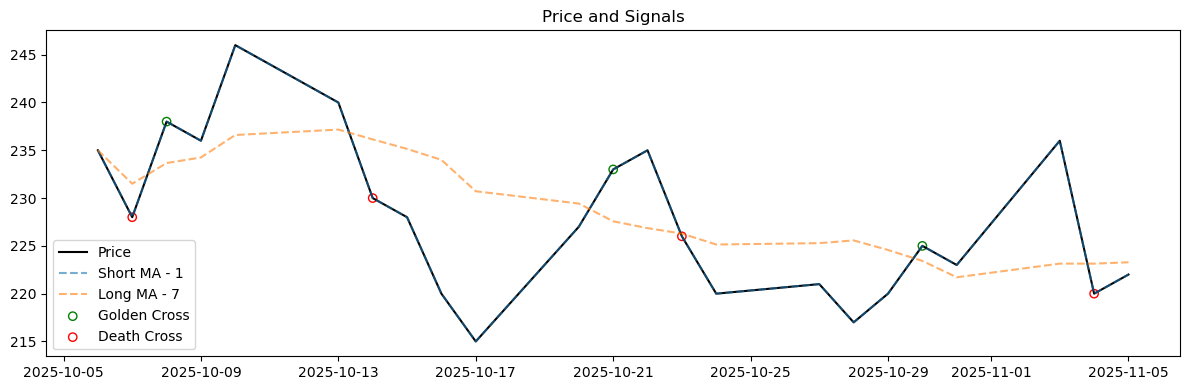

(Ticker          Price   Short_MA    Long_MA Signal  Crossover Price Trend
 Date                                                                     
 2025-10-06 235.000000 235.000000 235.000000   Hold      False   Downtrend
 2025-10-07 228.000000 228.000000 231.500000   Sell       True   Downtrend
 2025-10-08 238.000000 238.000000 233.666667    Buy       True     Uptrend
 2025-10-09 236.000000 236.000000 234.250000    Buy      False   Downtrend
 2025-10-10 246.000000 246.000000 236.600000    Buy      False     Uptrend
 2025-10-13 240.000000 240.000000 237.166667    Buy      False   Downtrend
 2025-10-14 230.000000 230.000000 236.142857   Sell       True   Downtrend
 2025-10-15 228.000000 228.000000 235.142857   Sell      False   Downtrend
 2025-10-16 220.000000 220.000000 234.000000   Sell      False   Downtrend
 2025-10-17 215.000000 215.000000 230.714286   Sell      False   Downtrend
 2025-10-20 227.000000 227.000000 229.428571   Sell      False     Uptrend
 2025-10-21 233.000000 23

In [157]:
##Worst combination  
metr_ma_crx_v1(data=df[["PPE.JO"]], start_date=less_params['Start'], end_date=less_params['End'], ma_upp=less_params['MA_upp'], 
               ma_lwr=less_params['MA_lwr'], lookahead=less_params['Lookahead'], plot=True)

In [155]:
#Analysis
results_df2 = results_df

# Clean the Score column
results_df2['Score'] = results_df2['Score'].astype(str).str.replace(',', '').astype(float)

# Descriptive statistics
print("Descriptive Statistics for 'Score':")
print(results_df2['Score'].describe())

# Group-wise average scores by Data
group_summary = results_df2.groupby(['Data'])['Score'].mean().reset_index()

print("\n Parameter Combinations by Data:")
print(group_summary.sort_values(by='Score', ascending=False))

# By Lookahead
group_summary = results_df2.groupby(['Lookahead'])['Score'].mean().reset_index()

print("\n Parameter Combinations by Lookahead:")
print(group_summary.sort_values(by='Score', ascending=False))

# By Moving Averages
group_summary = results_df2.groupby(['MA_lwr', 'MA_upp'])['Score'].mean().reset_index()

print("\nTop Parameter Combinations by MA:")
print(group_summary.sort_values(by='Score', ascending=False))


Descriptive Statistics for 'Score':
count    965.000000
mean      11.877301
std       75.329222
min     -400.181074
25%      -15.857410
50%        3.086926
75%       32.854288
max      364.885061
Name: Score, dtype: float64

 Parameter Combinations by Data:
       Data      Score
4    SSW.JO  57.702298
2    PPE.JO  15.029327
3       SPY  10.244995
1       EZA   8.523450
6      ^TYX   5.107823
0   BTC-USD   4.122720
5  USDZAR=X -17.638560

 Parameter Combinations by Lookahead:
   Lookahead     Score
1          2 18.322310
0          1 10.870178
2          4 10.610576
3          7  6.130862

Top Parameter Combinations by MA:
   MA_lwr  MA_upp     Score
6       7      10 31.661576
3       5       7 24.745360
4       5      10 24.295319
5       5      14 12.827153
7       7      14 12.782793
2       1      14  1.888871
1       1      10 -8.040861
0       1       7 -8.884004


## Conclusion




Write Analysis!

# Parabolic SAR (Stop and Reverse)

The Parabolic SAR (Stop and Reverse) is a technical analysis indicator used to identify potential trend reversals and set trailing stop-loss orders in trading. The position of the dots indicates the direction of the trend:

- Dots below the price suggest a bullish trend, indicating potential buying opportunities.
    
- Dots above the price indicate a bearish trend, suggesting potential selling or shorting opportunities. 

In [ ]:
def parabolic_sar(df, step=0.02, max_step=0.2):
    ##Parabolic SAR for given OHLC data.
    
    # Validate input
    if not {'High', 'Low'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'High' and 'Low' columns.")
    if step <= 0 or max_step <= 0:
        raise ValueError("Step and max_step must be positive.")
    if step > max_step:
        raise ValueError("Step cannot be greater than max_step.")

    # Initialize variables
    sar = df['Low'][0]  # Start SAR at first low
    ep = df['High'][0]  # Extreme Point
    af = step           # Acceleration Factor
    long_position = True
    sar_values = [sar]

    for i in range(1, len(df)):
        prev_sar = sar
        prev_ep = ep
        prev_af = af
        prev_long = long_position

        # Calculate SAR
        sar = prev_sar + prev_af * (prev_ep - prev_sar)

        if prev_long:
            # Ensure SAR does not exceed last two lows
            sar = min(sar, df['Low'][i-1], df['Low'][i])
            if df['High'][i] > prev_ep:
                ep = df['High'][i]
                af = min(prev_af + step, max_step)
            else:
                ep = prev_ep
                af = prev_af
            if df['Low'][i] < sar:
                long_position = False
                sar = prev_ep
                ep = df['Low'][i]
                af = step
        else:
            # Ensure SAR does not fall below last two highs
            sar = max(sar, df['High'][i-1], df['High'][i])
            if df['Low'][i] < prev_ep:
                ep = df['Low'][i]
                af = min(prev_af + step, max_step)
            else:
                ep = prev_ep
                af = prev_af
            if df['High'][i] > sar:
                long_position = True
                sar = prev_ep
                ep = df['High'][i]
                af = step

        sar_values.append(sar)

    return pd.Series(sar_values, index=df.index, name='Parabolic_SAR')



# Sample OHLC data
data = {
    'High': [10, 10.5, 10.8, 10.6, 11, 11.2, 11.5],
    'Low':  [9.5, 10.1, 10.3, 10.2, 10.6, 10.9, 11.1]
}
df = pd.DataFrame(data)
df['Parabolic_SAR'] = parabolic_sar(df)



In [177]:
#Create OHLC dataframe
low = df_l["PPE.JO"].rename("Low")
high = df_h["PPE.JO"].rename("High")

df_ohlc = pd.concat([low, high], axis=1)
print(df_ohlc.head())

                 Low      High
Date                          
2020-06-01 46.037399 55.832600
2020-06-02 48.975899 50.935001
2020-06-03 44.078300 49.955502
2020-06-04 44.078300 48.975899
2020-06-05 47.996399 50.935001


# Bollinger Bands

In [ ]:
# Define parameters
window_size = 20
num_std = 2

rolling_dat = df.index[window_size-1:]

# Calculate rolling mean and standard deviation
rolling_mean = np.convolve(df["SSW.JO"], np.ones(window_size)/window_size, mode='valid')
rolling_std = np.std([df["SSW.JO"][i:i+window_size] for i in range(len(df["SSW.JO"])-window_size+1)], axis=1)

# Calculate Bollinger Bands
upper_band = rolling_mean + num_std * rolling_std
lower_band = rolling_mean - num_std * rolling_std

rolling_df = pd.DataFrame({
                "Date": rolling_dat,
                "Mean": rolling_mean,
                "Std": rolling_std,
                "Upper": upper_band,
                "Lower": lower_band})

#Set index
rolling_df = rolling_df.set_index("Date")

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df["SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df["Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df["Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df["Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

In [ ]:
#Technical Works!

# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2025-01-01":"2025-10-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

In [ ]:
#Technical Does Not Works!

# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2024-03-01":"2024-06-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

# Moving Average Convergence/Divergence Oscillator (MACD)

In [ ]:
# Function to calculate MACD and Signal Line
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
   short_ema = prices.ewm(span=short_window, adjust=False).mean() # Short-term EMA
   long_ema = prices.ewm(span=long_window, adjust=False).mean() # Long-term EMA
    
   macd_line = short_ema - long_ema # MACD Line
    
   signal_line = macd_line.ewm(span=signal_window, adjust=False).mean() # Signal Line
    
   return macd_line, signal_line

In [ ]:
# Calculate MACD and Signal Line
macd_line, signal_line = calculate_macd(df["SSW.JO"])

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df["SSW.JO"], label='Closing Price')
plt.title('Stock Price and MACD of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(macd_line, label='MACD Line', color='red')
plt.plot(signal_line, label='Signal Line', color='green')
plt.legend()
plt.tight_layout()
plt.xlabel('Days')
plt.show()